In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
import catboost as ctb
import xgboost as xgb

In [13]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Models

In [14]:
models = {
    "RidgeCV_robust_scaler": make_pipeline(
        RobustScaler(), 
        RidgeCV(
            alphas = [7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20], 
            cv = kf,
        )
    ),
    "LassoCV_robust_scaler": make_pipeline(
        RobustScaler(),
        LassoCV(
            alphas = [0.0001, 0.0002, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008], 
            random_state = 42,
            cv = kf,
            max_iter = 2000,
        )
    ),
    "catboost": make_pipeline(
        ctb.CatBoostRegressor(
            silent=True,
        ),
    ),
    "ElasticNet": make_pipeline(
        RobustScaler(),
        ElasticNet(
            alpha=0.0005,
            l1_ratio=0.9,
            random_state=42
        )
    ),
    "SVR": make_pipeline(
        MinMaxScaler(), 
        SVR(
            C= 5, 
            epsilon= 0.001, 
            gamma=0.0001, 
            kernel = "linear"
        )
    ),
    "XGBRegressor": make_pipeline(
        xgb.XGBRegressor(
            colsample_bytree=0.4603, 
            gamma=0.0468, 
            learning_rate=0.05, 
            max_depth=3, 
            min_child_weight=1.7817, 
            n_estimators=2200,
            reg_alpha=0.4640, 
            reg_lambda=0.8571,
            subsample=0.5213, 
            random_state=7, 
            nthread= -1)
    ),
}

# Running experiments

In [15]:
def eval_metrics(X_train, actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    # mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    n = len(X_train)
    p = len(X_train.columns) - 1
    adjusted_r2 = 1 - ((1-r2) * (n-1)/(n-p-1)) 
    return rmse, r2, adjusted_r2

def evaluation(results):
    df_results = pd.DataFrame(results)
    df_results = pd.concat([df_results, df_results['metrics_train'].apply(pd.Series, index=['RMSE_train', 'R2_train', 'R2_adjusted_train'])], axis=1)
    df_results = df_results.drop(columns=['metrics_train'])
    df_results = pd.concat([df_results, df_results['metrics_test'].apply(pd.Series, index=['RMSE_test', 'R2_test', 'R2_adjusted_test'])], axis=1)
    df_results = df_results.drop(columns=['metrics_test'])
    return df_results

def run_experiment(data):

    # Load your dataset, or create a sample dataset
    X = data.drop(["SalePrice"], axis=1)
    y = data["SalePrice"]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = {
        "Model": [],
        "cross_validation": [],
        "metrics_train" : [],
        "metrics_test" : [],
    }

    # Determine the number of rows based on the number of models
    num_models = len(models)
    num_columns = 2
    num_rows = (num_models + num_columns - 1) // num_columns  # Calculate the number of rows

    # Create a grid of subplots with 2 columns and the calculated number of rows
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, 5 * num_rows))

    for i, model in enumerate(models):
        print(f"-------------------- {model} --------------------")
        results["Model"].append(model)

        models[model].fit(X_train, y_train)

        y_train_pred = models[model].predict(X_train)
        rmse_tr, r2_tr, r2_ajd_tr = eval_metrics(X_train, y_train, y_train_pred)
        results["metrics_train"].append([rmse_tr, r2_tr, r2_ajd_tr])

        y_pred = models[model].predict(X_test)
        rmse_tes, r2_tes, r2_ajd_tes = eval_metrics(X_train, y_test, y_pred)
        results["metrics_test"].append([rmse_tes, r2_tes, r2_ajd_tes])

        print(f"{model} RMSE (training): {rmse_tr} | RMSE (testing): {rmse_tes}")
        print(f"{model} R2 (training): {r2_tr} | R2 (testing): {r2_tes}")
        print(f"{model} R2 adj (training): {r2_ajd_tr} | R2 adj (testing): {r2_ajd_tes}")

        rmse_cv = np.mean(
            np.sqrt(
                -cross_val_score(
                    models[model],
                    X_train, 
                    y_train, 
                    cv = kf, 
                    scoring = "neg_mean_squared_error")
            )
        )
        print(f"{model} rmse cross_validation: {rmse_cv}")
        results["cross_validation"].append(rmse_cv)
        
        # Determine the subplot position within the grid
        row = i // num_columns  # Calculate the row index
        col = i % num_columns   # Calculate the column index

        axs[row, col].scatter(y_test, y_pred, color="teal", edgecolor='lightblue')
        axs[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=0.2)
        axs[row, col].set_title(model)
        axs[row, col].set_xlabel('Actual')
        axs[row, col].set_ylabel('Predicted') 


    plt.show();
    return results


-------------------- RidgeCV_robust_scaler --------------------
RidgeCV_robust_scaler RMSE (training): 0.10311294363717383 | RMSE (testing): 0.12915803505924534
RidgeCV_robust_scaler R2 (training): 0.9324617041714672 | R2 (testing): 0.9010430197294202
RidgeCV_robust_scaler R2 adj (training): 0.8996401598976522 | R2 adj (testing): 0.8529529566132329
RidgeCV_robust_scaler rmse cross_validation: 0.12149613460424229
-------------------- LassoCV_robust_scaler --------------------
LassoCV_robust_scaler RMSE (training): 0.10769532806520304 | RMSE (testing): 0.13092553421969194
LassoCV_robust_scaler R2 (training): 0.9263254562790014 | R2 (testing): 0.8983160789387983
LassoCV_robust_scaler R2 adj (training): 0.8905218833737713 | R2 adj (testing): 0.8489008060761479
LassoCV_robust_scaler rmse cross_validation: 0.12279266675137017
-------------------- catboost --------------------
catboost RMSE (training): 0.04343072083241216 | RMSE (testing): 0.13618336292706842
catboost R2 (training): 0.9880183

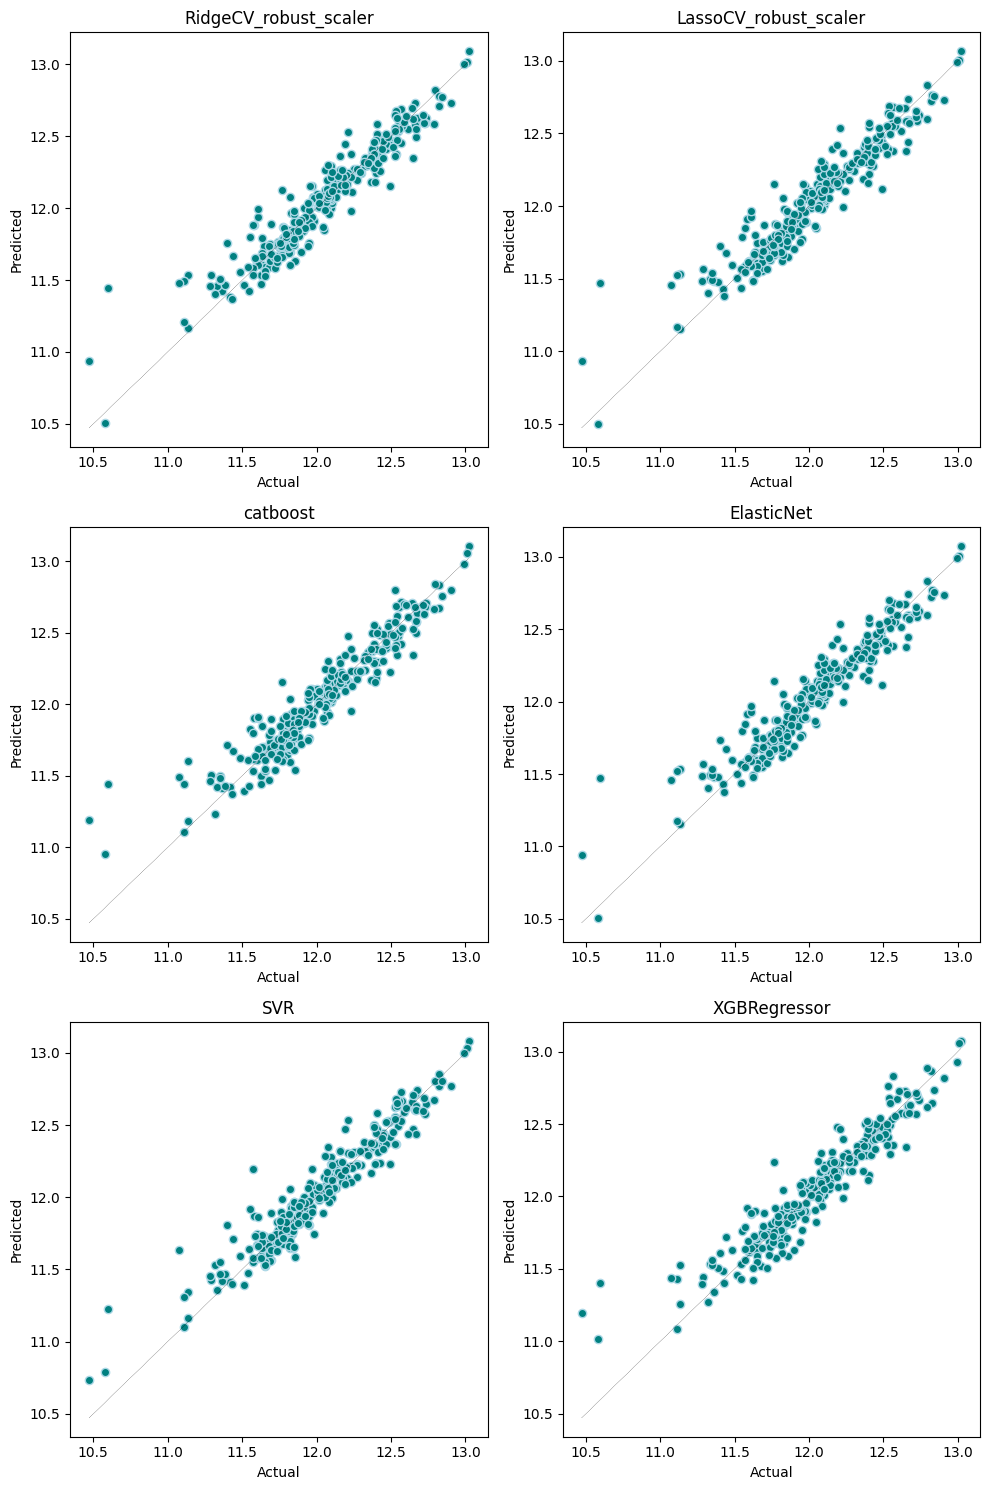

,Model,cross_validation,RMSE_train,R2_train,R2_adjusted_train,RMSE_test,R2_test,R2_adjusted_test
0,RidgeCV_robust_scaler,0.121496,0.103113,0.932462,0.899640,0.129158,0.901043,0.852953
1,LassoCV_robust_scaler,0.122793,0.107695,0.926325,0.890522,0.130926,0.898316,0.848901
2,catboost,0.125867,0.043431,0.988018,0.982196,0.136183,0.889985,0.836521
3,ElasticNet,0.122752,0.106672,0.927718,0.892592,0.131373,0.897620,0.847866
4,SVR,0.146021,0.096974,0.940264,0.911234,0.122861,0.910457,0.866942
5,XGBRegressor,0.127715,0.093273,0.944736,0.917880,0.135905,0.890434,0.837188


In [16]:
data = pd.read_csv("dataset_training_final.csv")
results = run_experiment(data)
evaluation_results = evaluation(results)
columns = ['cross_validation', 'RMSE_train', 'RMSE_test', 'R2_train', 'R2_test', 'R2_adjusted_train', 'R2_adjusted_test']
evaluation_results.style.highlight_max(axis=0, props='background-color:green;', subset=columns).highlight_min(axis=0, props='background-color:red;', subset=columns)